In [48]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

In [49]:
np.random.seed(123)

# Main Question
Consider a portfolio with 2 BBB bonds with two different counterparties, with marginal default probabilities given by the table.

Dependency structure given by:
A: A multivariate Gaussian distribution with a correlation of 0.5
B: A Gaussian copula with correlation 0.5

1. Simulate 1million future portfolio values to calculate the expected credit loss and the 99% quantile of the loss distribution
2. compare A and B above, which one produces a higher loss prediction? can you tell why?
 

# Generate the transition probability table 

In [50]:
TblBond = pd.DataFrame({
    'Rating': ['AAA', 'AA', 'A', 'BBB', 'BB', 'B', 'CCC', 'Default'],
    'PD': [0.02, 0.33, 5.95, 86.93, 5.30, 1.17, 0.12, 0.18],
    'TransitionValue': [109.37, 109.19, 108.66, 107.55, 102.02, 98.1, 83.64, 51.13]
})
TblBond['Probability'] = TblBond['PD'] / 100
TblBond['CumProbability'] = TblBond['Probability'].iloc[::-1].cumsum()
TblBond['Inverse_normal'] = stats.norm.ppf(TblBond['CumProbability'])
TblBond

,Rating,PD,TransitionValue,Probability,CumProbability,Inverse_normal
0,AAA,0.02,109.37,0.0002,1.0000,inf
1,AA,0.33,109.19,0.0033,0.9998,3.540084
2,A,5.95,108.66,0.0595,0.9965,2.696844
3,BBB,86.93,107.55,0.8693,0.9370,1.530068
4,BB,5.30,102.02,0.0530,0.0677,-1.493142
5,B,1.17,98.10,0.0117,0.0147,-2.178081
6,CCC,0.12,83.64,0.0012,0.0030,-2.747781
7,Default,0.18,51.13,0.0018,0.0018,-2.911238


# Part A: assume the two BBB bonds are dependent with a multivariate Gaussian distribution with a correlation of 0.5

In [51]:
N = 1_000_000
correlation = 0.5
vcov = np.array([[1, correlation], [correlation, 1]])
U1 = stats.norm.ppf(np.random.uniform(size=N))
U2 = stats.norm.ppf(np.random.uniform(size=N))
U = np.array([U1, U2]).T

In [52]:
Z = np.linalg.cholesky(vcov) @ U.T
Z = Z.T

In [53]:
np.corrcoef(Z, rowvar=False)

array([[1.        , 0.49968674],
       [0.49968674, 1.        ]])

## Plot random number distribution

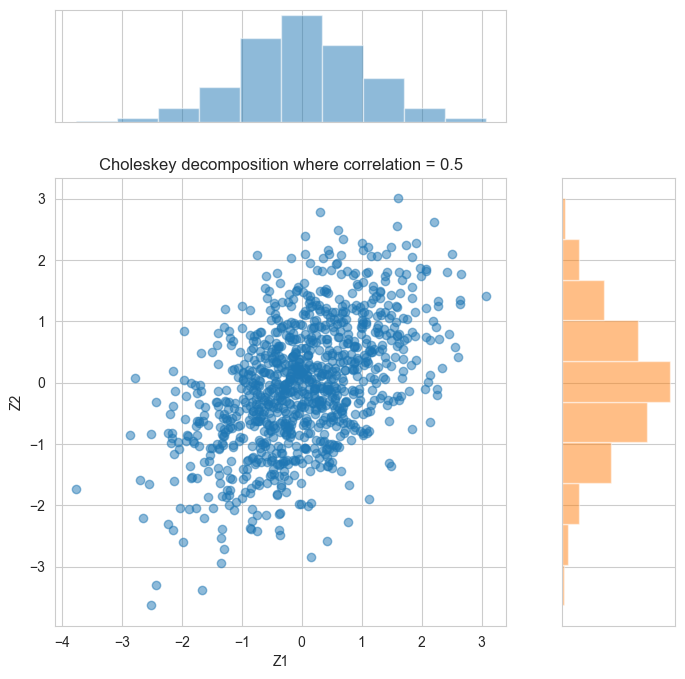

In [54]:
x = Z[:1000, 0]
y = Z[:1000, 1]
# Create a 2x2 grid for the plots
fig = plt.figure(figsize=(8, 8))
gs = fig.add_gridspec(2, 2, width_ratios=[4, 1], height_ratios=[1, 4])
ax_scatter = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax_scatter)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax_scatter)

# Scatter plot
ax_scatter.scatter(x, y, alpha=0.5)

# Histogram for x
ax_histx.hist(x, alpha=0.5, color='tab:blue')
ax_histx.set_yticks([])

# Histogram for y
ax_histy.hist(y, alpha=0.5, color='tab:orange', orientation='horizontal')
ax_histy.set_xticks([])

# Set labels
ax_scatter.set_xlabel('Z1')
ax_scatter.set_ylabel('Z2')

# Remove shared axis labels
plt.setp(ax_histx.get_xticklabels(), visible=False)
plt.setp(ax_histy.get_yticklabels(), visible=False)

ax_scatter.set_title('Choleskey decomposition where correlation = 0.5')

# Show the plot
plt.show()

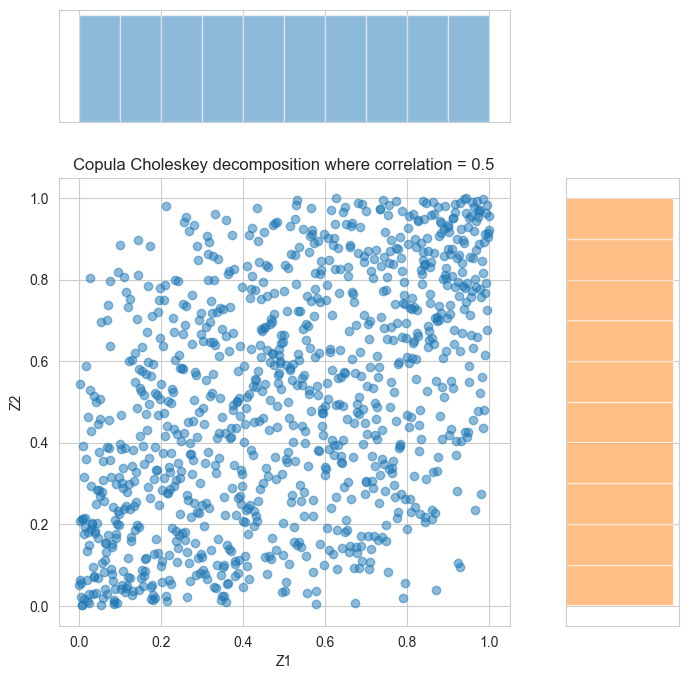

In [55]:
x = stats.rankdata(Z[:1000, 0]) / 1000
y = stats.rankdata(Z[:1000, 1]) / 1000
# Create a 2x2 grid for the plots
fig = plt.figure(figsize=(8, 8))
gs = fig.add_gridspec(2, 2, width_ratios=[4, 1], height_ratios=[1, 4])
ax_scatter = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax_scatter)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax_scatter)

# Scatter plot
ax_scatter.scatter(x, y, alpha=0.5)

# Histogram for x
ax_histx.hist(x, alpha=0.5, color='tab:blue')
ax_histx.set_yticks([])

# Histogram for y
ax_histy.hist(y, alpha=0.5, color='tab:orange', orientation='horizontal')
ax_histy.set_xticks([])

# Set labels
ax_scatter.set_xlabel('Z1')
ax_scatter.set_ylabel('Z2')

# Remove shared axis labels
plt.setp(ax_histx.get_xticklabels(), visible=False)
plt.setp(ax_histy.get_yticklabels(), visible=False)

ax_scatter.set_title('Copula Choleskey decomposition where correlation = 0.5')

# Show the plot
plt.show()

## From random generator to actural default probability then to PNL

In [56]:
current_portfolio_value = 2 * (TblBond['Probability'] * TblBond['TransitionValue']).sum()# here we assume that the two bonds have the same value, and their value is derived based on the expected rating change * transition value

In [57]:
criterion = TblBond['Inverse_normal'].tolist()
criterion.append(-np.inf)
criterion = np.array(criterion)

In [58]:
digitized_z = np.digitize(Z, criterion) - 1

In [59]:
end_val = np.vstack([[TblBond['TransitionValue'][idx] for idx in digitized_z[:, 0]],
                     [TblBond['TransitionValue'][idx] for idx in digitized_z[:, 1]]]).T

In [60]:
end_val = end_val.sum(axis=1)

In [61]:
Pnl_multivariate_Gaussian = end_val - current_portfolio_value

## PnL plot

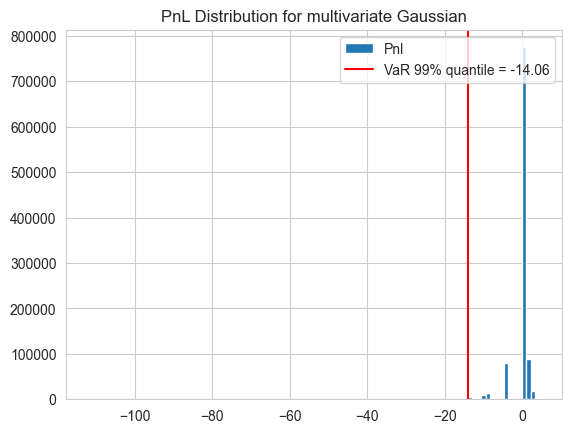

In [62]:
plt.hist(Pnl_multivariate_Gaussian, bins=100, label='Pnl')
plt.axvline(np.percentile(Pnl_multivariate_Gaussian, 1), color='red',
            label='VaR 99% quantile = {:.2f}'.format(np.percentile(Pnl_multivariate_Gaussian, 1)))
plt.legend(loc='upper right')
plt.title('PnL Distribution for multivariate Gaussian')
plt.show()

# Part B: assume the two BBB bonds are dependent with a Gaussian copula with correlation of 0.5

In [63]:
from statsmodels.distributions.copula.api import GaussianCopula

In [64]:
Copula_z = GaussianCopula(corr=correlation).rvs(N)

In [65]:
Copula_z = stats.norm.ppf(Copula_z)

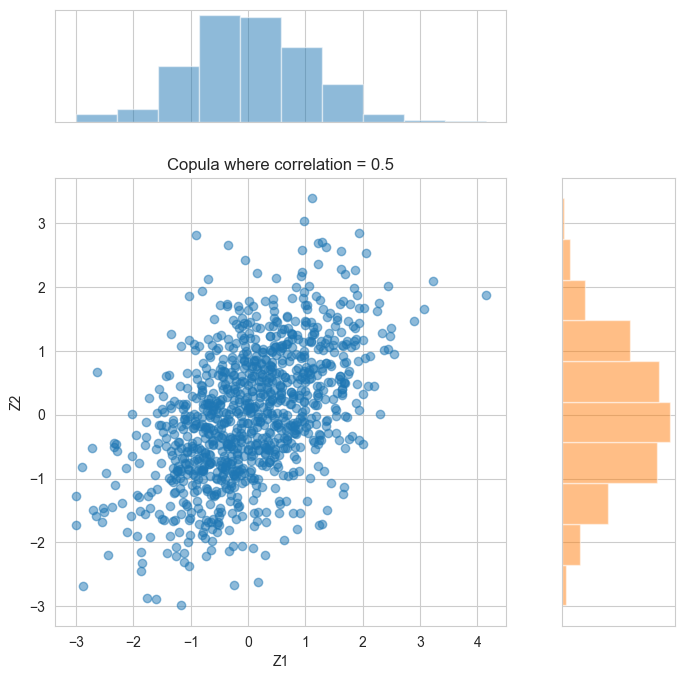

In [66]:
x = Copula_z[:1000, 0]
y = Copula_z[:1000, 1]
# Create a 2x2 grid for the plots
fig = plt.figure(figsize=(8, 8))
gs = fig.add_gridspec(2, 2, width_ratios=[4, 1], height_ratios=[1, 4])
ax_scatter = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax_scatter)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax_scatter)

# Scatter plot
ax_scatter.scatter(x, y, alpha=0.5)

# Histogram for x
ax_histx.hist(x, alpha=0.5, color='tab:blue')
ax_histx.set_yticks([])

# Histogram for y
ax_histy.hist(y, alpha=0.5, color='tab:orange', orientation='horizontal')
ax_histy.set_xticks([])

# Set labels
ax_scatter.set_xlabel('Z1')
ax_scatter.set_ylabel('Z2')

# Remove shared axis labels
plt.setp(ax_histx.get_xticklabels(), visible=False)
plt.setp(ax_histy.get_yticklabels(), visible=False)

ax_scatter.set_title('Copula where correlation = 0.5')

# Show the plot
plt.show()

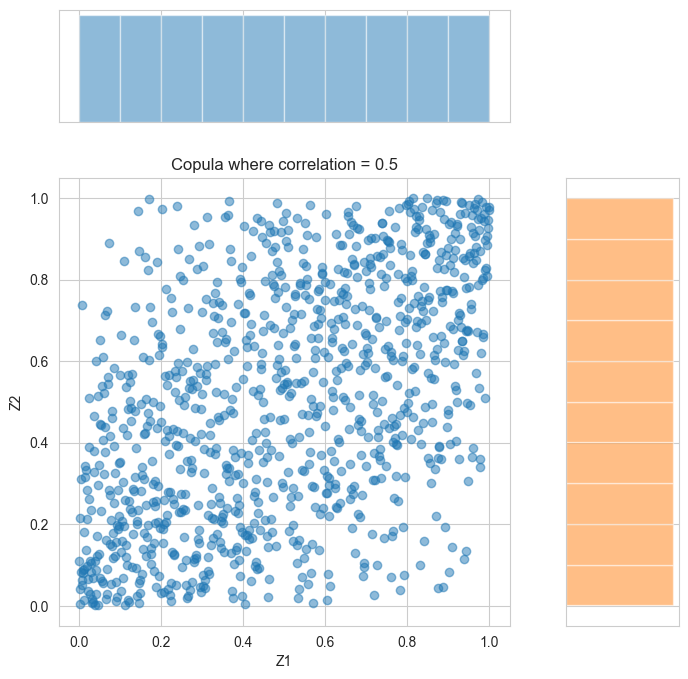

In [67]:
x = stats.rankdata(Copula_z[:1000, 0]) / 1000
y = stats.rankdata(Copula_z[:1000, 1]) / 1000
# Create a 2x2 grid for the plots
fig = plt.figure(figsize=(8, 8))
gs = fig.add_gridspec(2, 2, width_ratios=[4, 1], height_ratios=[1, 4])
ax_scatter = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax_scatter)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax_scatter)

# Scatter plot
ax_scatter.scatter(x, y, alpha=0.5)

# Histogram for x
ax_histx.hist(x, alpha=0.5, color='tab:blue')
ax_histx.set_yticks([])

# Histogram for y
ax_histy.hist(y, alpha=0.5, color='tab:orange', orientation='horizontal')
ax_histy.set_xticks([])

# Set labels
ax_scatter.set_xlabel('Z1')
ax_scatter.set_ylabel('Z2')

# Remove shared axis labels
plt.setp(ax_histx.get_xticklabels(), visible=False)
plt.setp(ax_histy.get_yticklabels(), visible=False)

ax_scatter.set_title('Copula where correlation = 0.5')

# Show the plot
plt.show()

In [68]:
digitized_z_copula = np.digitize(Copula_z, criterion) - 1
# criterion_copula = TblBond['CumProbability'].tolist()
# criterion_copula.append(0)
# digitized_z_copula = np.digitize(Copula_z,criterion_copula)-1

In [69]:
end_val_copula = np.vstack([[TblBond['TransitionValue'][idx] for idx in digitized_z_copula[:, 0]],
                            [TblBond['TransitionValue'][idx] for idx in digitized_z_copula[:, 1]]]).T

In [70]:
end_val_copula = end_val_copula.sum(axis=1)

In [71]:
PnL_copula = end_val_copula - current_portfolio_value

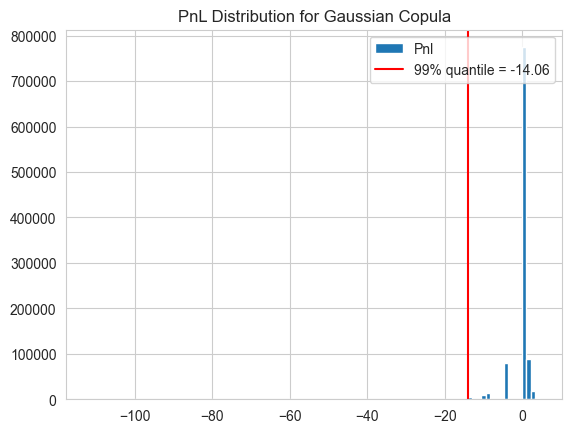

In [72]:
plt.hist(PnL_copula, bins=100, label='Pnl')
plt.axvline(np.percentile(PnL_copula, 1), color='red',
            label='99% quantile = {:.2f}'.format(np.percentile(PnL_copula, 1)))
plt.legend(loc='upper right')
plt.title('PnL Distribution for Gaussian Copula')
plt.show()

# The expected PnL

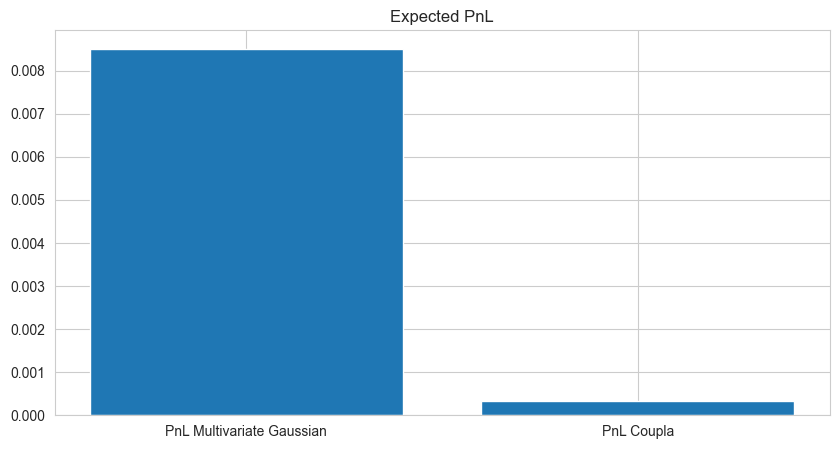

In [73]:
plt.figure(figsize=(10, 5))
plt.bar(['PnL Multivariate Gaussian','PnL Coupla'],[Pnl_multivariate_Gaussian.mean(), PnL_copula.mean()])
plt.title('Expected PnL')
plt.show()

# The expected LOSS

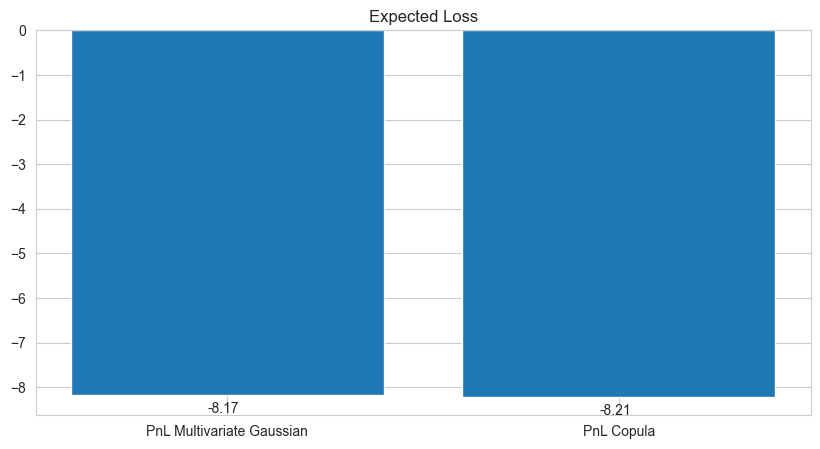

In [74]:
plt.figure(figsize=(10, 5))
plt.bar(['PnL Multivariate Gaussian','PnL Copula'],[Pnl_multivariate_Gaussian[Pnl_multivariate_Gaussian<0].mean(), PnL_copula[PnL_copula<0].mean()])
plt.title('Expected Loss')
for i, v in enumerate([Pnl_multivariate_Gaussian[Pnl_multivariate_Gaussian<0].mean(), PnL_copula[PnL_copula<0].mean()]):
    plt.text(i-0.05 , v -0.4, str(round(v, 2)))
plt.show()

# Plotting the two methods together

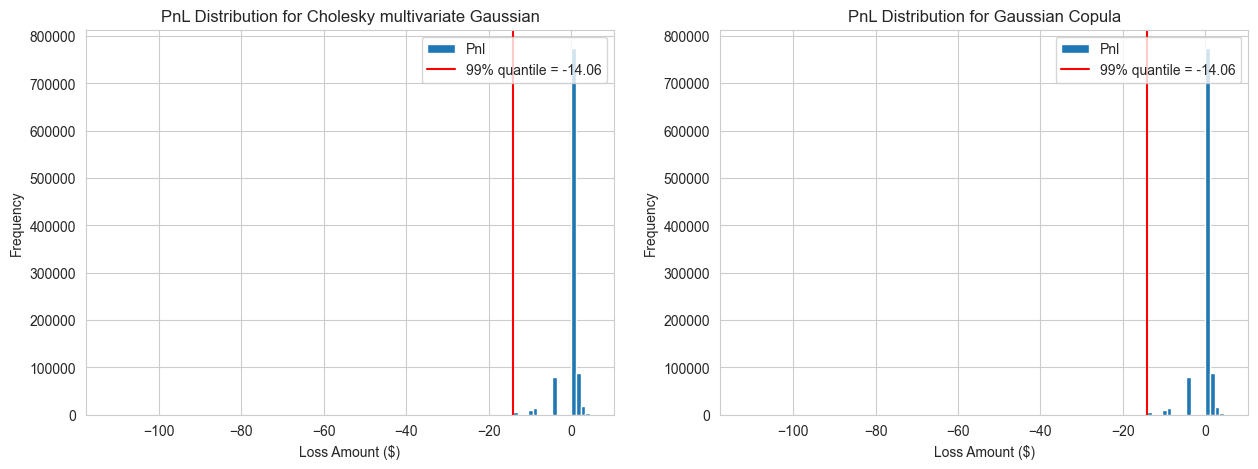

In [75]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.hist(Pnl_multivariate_Gaussian, bins=100, label='Pnl')
plt.axvline(np.percentile(Pnl_multivariate_Gaussian, 1), color='red',
            label='VaR 99% quantile = {:.2f}'.format(np.percentile(Pnl_multivariate_Gaussian, 1)))
plt.legend(loc='upper right')
plt.ylabel('Frequency')
plt.xlabel('Loss Amount ($)')
plt.title('PnL Distribution for Cholesky multivariate Gaussian')
plt.subplot(1, 2, 2)
plt.hist(PnL_copula, bins=100, label='Pnl')
plt.axvline(np.percentile(PnL_copula, 1), color='red',
            label='VaR 99% quantile = {:.2f}'.format(np.percentile(PnL_copula, 1)))
plt.legend(loc='upper right')
plt.ylabel('Frequency')
plt.xlabel('Loss Amount ($)')
plt.title('PnL Distribution for Gaussian Copula')
plt.show()

Expected Shortfall calculation

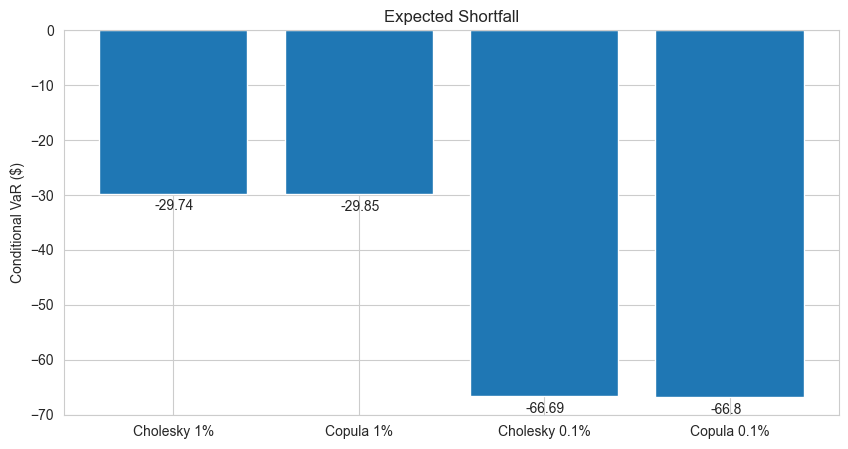

In [79]:
ES = [
    np.mean(Pnl_multivariate_Gaussian[Pnl_multivariate_Gaussian <= np.percentile(Pnl_multivariate_Gaussian, 1)]),
    np.mean(PnL_copula[PnL_copula <= np.percentile(PnL_copula, 1)]),
    np.mean(Pnl_multivariate_Gaussian[Pnl_multivariate_Gaussian <= np.percentile(Pnl_multivariate_Gaussian, 0.1)]),
    np.mean(PnL_copula[PnL_copula <= np.percentile(PnL_copula, 0.1)]),
]
# plot bar plot for ES
plt.figure(figsize=(10, 5))
plt.bar(['Cholesky 1%', 'Copula 1%', 'Cholesky 0.1%', 'Copula 0.1%'], ES)
plt.title('Expected Shortfall')
for i, v in enumerate(ES):
    plt.text(i - 0.1, v - 3, str(round(v, 2)))
plt.ylabel('Conditional VaR ($)')
plt.show()

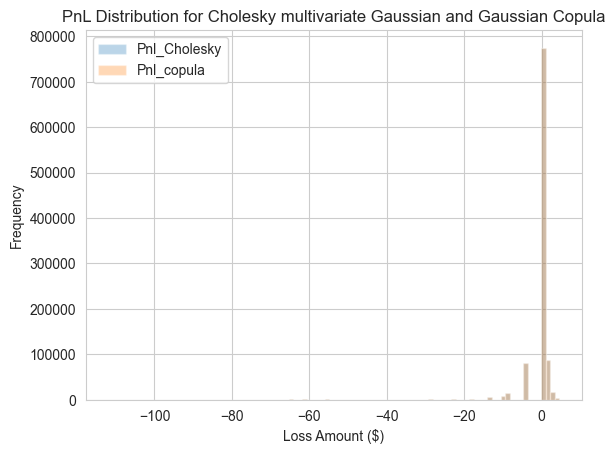

In [77]:
plt.hist(Pnl_multivariate_Gaussian, bins=100, label='Pnl_Cholesky', alpha=0.3)
plt.hist(PnL_copula, bins=100, label='Pnl_copula', alpha=0.3)
plt.title('PnL Distribution for Cholesky multivariate Gaussian and Gaussian Copula')
plt.legend(loc='upper left')
plt.ylabel('Frequency')
plt.xlabel('Loss Amount ($)')
plt.show()

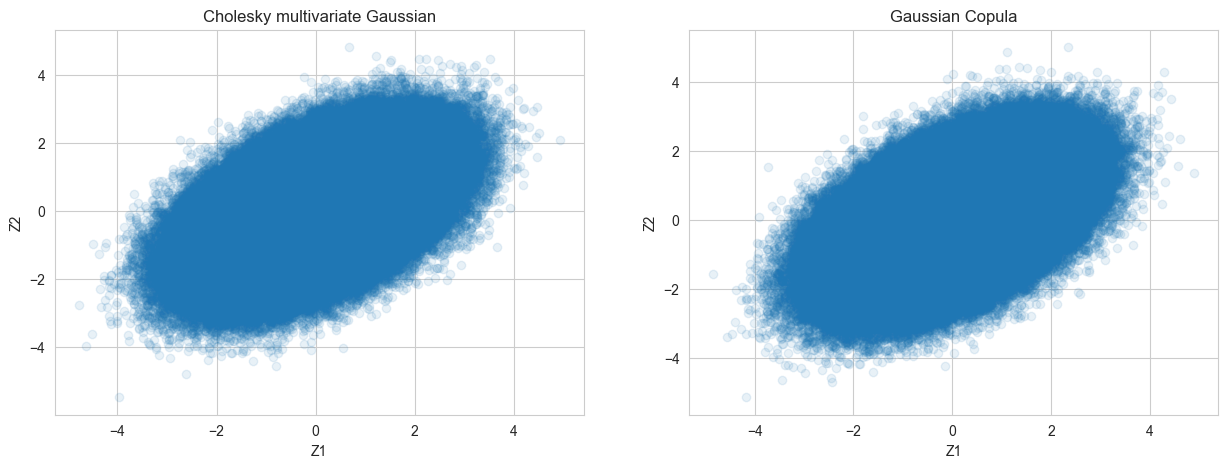

In [78]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.scatter(Z[:, 0], Z[:, 1], alpha=0.1)
plt.title('Cholesky multivariate Gaussian')
plt.xlabel('Z1')
plt.ylabel('Z2')
plt.subplot(1, 2, 2)
plt.scatter(Copula_z[:, 0], Copula_z[:, 1], alpha=0.1)
plt.title('Gaussian Copula')
plt.xlabel('Z1')
plt.ylabel('Z2')
plt.show()

# Conclusion:
Gaussian multi-variate produces the same result as Gaussian copula. This is because they are fundamentally the same when it comes to gaussian distribution. Choleskey decomposition is the simplified version of Gaussian copula. Copula method can be used for any distribution, but Choleskey decomposition can only be used for Gaussian distribution. 